##### Copyright 2020 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Calculate gradients

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/gradients"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/gradients.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/gradients.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/gradients.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial explores gradient calculation algorithms for the expectation values of quantum circuits.

Calculating the gradient of the expectation value of a certain observable in a quantum circuit is an involved process. Expectation values of observables do not have the luxury of having analytic gradient formulas that are always easy to write down—unlike traditional machine learning transformations such as matrix multiplication or vector addition that have analytic gradient formulas which are easy to write down. As a result, there are different quantum gradient calculation methods that come in handy for different scenarios. This tutorial compares and contrasts two different differentiation schemes.

## Setup

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

Install TensorFlow Quantum:

In [1]:
#!pip install tensorflow-quantum

Now import TensorFlow and the module dependencies:

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Preliminary

Let's make the notion of gradient calculation for quantum circuits a little more concrete. Suppose you have a parameterized circuit like this one:

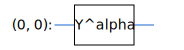

In [2]:
qubit = cirq.GridQubit(0, 0)
my_circuit = cirq.Circuit(cirq.Y(qubit)**sympy.Symbol('alpha'))
SVGCircuit(my_circuit)

Along with an observable:

In [3]:
pauli_x = cirq.X(qubit)
pauli_x

cirq.X.on(cirq.GridQubit(0, 0))

Looking at this operator you know that $⟨Y(\alpha)| X | Y(\alpha)⟩ = \sin(\pi \alpha)$

In [4]:
def my_expectation(op, alpha):
    """Compute ⟨Y(alpha)| `op` | Y(alpha)⟩"""
    params = {'alpha': alpha}
    sim = cirq.Simulator()
    final_state = sim.simulate(my_circuit, params).final_state
    return op.expectation_from_wavefunction(final_state, {qubit: 0}).real


my_alpha = 0.3
print("Expectation=", my_expectation(pauli_x, my_alpha))
print("Sin Formula=", np.sin(np.pi * my_alpha))

Expectation= 0.80901700258255
Sin Formula= 0.8090169943749473


 and if you define $f_{1}(\alpha) = ⟨Y(\alpha)| X | Y(\alpha)⟩$ then $f_{1}^{'}(\alpha) = \pi \cos(\pi \alpha)$. Let's check this:

In [5]:
def my_grad(obs, alpha, eps=0.01):
    grad = 0
    f_x = my_expectation(obs, alpha)
    f_x_prime = my_expectation(obs, alpha + eps)
    return ((f_x_prime - f_x) / eps).real


print('Finite difference:', my_grad(pauli_x, my_alpha))
print('Cosine formula:   ', np.pi * np.cos(np.pi * my_alpha))

Finite difference: 1.8063604831695557
Cosine formula:    1.846581830490457


## 2. The need for a differentiator

With larger circuits, you won't always be so lucky to have a formula that precisely calculates the gradients of a given quantum circuit. In the event that a simple formula isn't enough to calculate the gradient, the `tfq.differentiators.Differentiator` class allows you to define algorithms for computing the gradients of your circuits. For instance you can recreate the above example in TensorFlow Quantum (TFQ) with:

In [6]:
expectation_calculation = tfq.layers.Expectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

expectation_calculation(my_circuit,
                        operators=pauli_x,
                        symbol_names=['alpha'],
                        symbol_values=[[my_alpha]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8090171]], dtype=float32)>

However, if you switch to estimating expectation based on sampling (what would happen on a true device) the values can change a little bit. This means you now have an imperfect estimate:

In [48]:
sampled_expectation_calculation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))
np.random.seed(12)
res = sampled_expectation_calculation(my_circuit,
                                operators=pauli_x,
                                repetitions=1000,
                                symbol_names=['alpha'],
                                symbol_values=[[my_alpha]])
res2 = sampled_expectation_calculation(my_circuit,
                                operators=pauli_x,
                                repetitions=1000,
                                symbol_names=['alpha'],
                                symbol_values=[[my_alpha]])
print(res, res2)

tf.Tensor([[0.792]], shape=(1, 1), dtype=float32) tf.Tensor([[0.792]], shape=(1, 1), dtype=float32)


This can quickly compound into a serious accuracy problem when it comes to gradients:

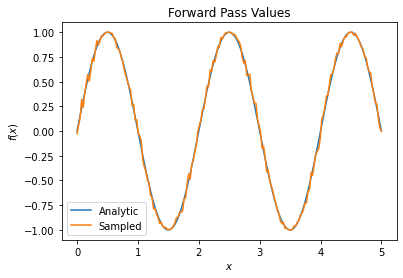

In [69]:
# Make input_points = [batch_size, 1] array.
input_points = np.linspace(0, 5, 200)[:, np.newaxis].astype(np.float32)
exact_outputs = expectation_calculation(my_circuit,
                                        operators=pauli_x,
                                        symbol_names=['alpha'],
                                        symbol_values=input_points)
imperfect_outputs = sampled_expectation_calculation(my_circuit,
                                                    operators=pauli_x,
                                                    repetitions=500,
                                                    symbol_names=['alpha'],
                                                    symbol_values=input_points)
plt.title('Forward Pass Values')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.plot(input_points, exact_outputs, label='Analytic')
plt.plot(input_points, imperfect_outputs, label='Sampled')
plt.legend()

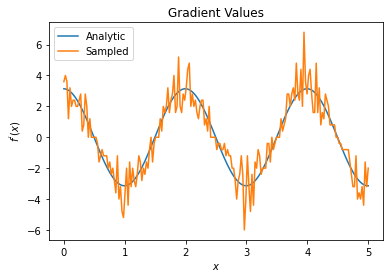

In [70]:
# Gradients are a much different story.
values_tensor = tf.convert_to_tensor(input_points)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    exact_outputs = expectation_calculation(my_circuit,
                                            operators=pauli_x,
                                            symbol_names=['alpha'],
                                            symbol_values=values_tensor)
analytic_finite_diff_gradients = g.gradient(exact_outputs, values_tensor)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = sampled_expectation_calculation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)
sampled_finite_diff_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_finite_diff_gradients, label='Sampled')
plt.legend()

Here you can see that although the finite difference formula is fast to compute the gradients themselves in the analytical case, when it came to the sampling based methods it was far too noisy. More careful techniques must be used to ensure a good gradient can be calculated. Next you will look at a much slower technique that wouldn't be as well suited for analytical expectation gradient calculations, but does perform much better in the real-world sample based case:

In [82]:
gradient_safe_sampled_expectation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ParameterShift())

gradient_safe_sampled_expectation(
    my_circuit,
    operators=pauli_x,
    repetitions=1000,
    symbol_names=['alpha'],
    symbol_values=[[0.3]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.782]], dtype=float32)>

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 77)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 77)


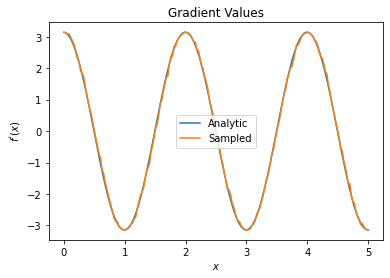

In [71]:
# A smarter differentiation scheme.
gradient_safe_sampled_expectation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ParameterShift())

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = gradient_safe_sampled_expectation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)

sampled_param_shift_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_param_shift_gradients, label='Sampled')
plt.legend()

From the above you can see that certain differentiators are best used for particular research scenarios. In general, the slower sample-based methods that are robust to device noise, etc., are great differentiators when testing or implementing algorithms in a more "real world" setting. Faster methods like finite difference are great for analytical calculations and you want higher throughput, but aren't yet concerned with the device viability of your algorithm.

## 3. Multiple observables

Let's introduce a second observable and see how TensorFlow Quantum supports multiple observables for a single circuit.

In [83]:
pauli_z = cirq.Z(qubit)
pauli_z

cirq.Z.on(cirq.GridQubit(0, 0))

If this observable is used with the same circuit as before, then you have $f_{2}(\alpha) = ⟨Y(\alpha)| Z | Y(\alpha)⟩ = \cos(\pi \alpha)$ and $f_{2}^{'}(\alpha) = -\pi \sin(\pi \alpha)$. Perform a quick check:

In [84]:
test_value = 0.

print('Finite difference:', my_grad(pauli_z, test_value))
print('Sin formula:      ', -np.pi * np.sin(np.pi * test_value))

Finite difference: -0.04934072494506836
Sin formula:       -0.0


It's a match (close enough).

Now if you define $g(\alpha) = f_{1}(\alpha) + f_{2}(\alpha)$ then $g'(\alpha) = f_{1}^{'}(\alpha) + f^{'}_{2}(\alpha)$. Defining more than one observable in TensorFlow Quantum to use along with a circuit is equivalent to adding on more terms to $g$.

This means that the gradient of a particular symbol in a circuit is equal to the sum of the gradients with regards to each observable for that symbol applied to that circuit. This is compatible with TensorFlow gradient taking and backpropagation (where you give the sum of the gradients over all observables as the gradient for a particular symbol).

In [85]:
sum_of_outputs = tfq.layers.Expectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

sum_of_outputs(my_circuit,
               operators=[pauli_x, pauli_z],
               symbol_names=['alpha'],
               symbol_values=[[test_value]])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>

Here you see the first entry is the expectation w.r.t Pauli X, and the second is the expectation w.r.t Pauli Z. Now when you take the gradient:

In [86]:
test_value_tensor = tf.convert_to_tensor([[test_value]])

with tf.GradientTape() as g:
    g.watch(test_value_tensor)
    outputs = sum_of_outputs(my_circuit,
                             operators=[pauli_x, pauli_z],
                             symbol_names=['alpha'],
                             symbol_values=test_value_tensor)

sum_of_gradients = g.gradient(outputs, test_value_tensor)

print(my_grad(pauli_x, test_value) + my_grad(pauli_z, test_value))
print(sum_of_gradients.numpy())

3.0917350202798843
[[3.0917215]]


Here you have verified that the sum of the gradients for each observable is indeed the gradient of $\alpha$. This behavior is supported by all TensorFlow Quantum differentiators and plays a crucial role in the compatibility with the rest of TensorFlow.

## 4. Advanced usage
Here you will learn how to define your own custom differentiation routines for quantum circuits.
All differentiators that exist inside of TensorFlow Quantum subclass `tfq.differentiators.Differentiator`. A differentiator must implement `differentiate_analytic` and `differentiate_sampled`.

The following uses TensorFlow Quantum constructs to implement the closed form solution from the first part of this tutorial.

In [87]:
class MyDifferentiator(tfq.differentiators.Differentiator):
    """A Toy differentiator for <Y^alpha | X |Y^alpha>."""

    def __init__(self):
        pass

    @tf.function
    def _compute_gradient(self, symbol_values):
        """Compute the gradient based on symbol_values."""

        # f(x) = sin(pi * x)
        # f'(x) = pi * cos(pi * x)
        return tf.cast(tf.cos(symbol_values * np.pi) * np.pi, tf.float32)

    @tf.function
    def differentiate_analytic(self, programs, symbol_names, symbol_values,
                               pauli_sums, forward_pass_vals, grad):
        """Specify how to differentiate a circuit with analytical expectation.

        This is called at graph runtime by TensorFlow. `differentiate_analytic`
        should calculate the gradient of a batch of circuits and return it
        formatted as indicated below. See
        `tfq.differentiators.ForwardDifference` for an example.

        Args:
            programs: `tf.Tensor` of strings with shape [batch_size] containing
                the string representations of the circuits to be executed.
            symbol_names: `tf.Tensor` of strings with shape [n_params], which
                is used to specify the order in which the values in
                `symbol_values` should be placed inside of the circuits in
                `programs`.
            symbol_values: `tf.Tensor` of real numbers with shape
                [batch_size, n_params] specifying parameter values to resolve
                into the circuits specified by programs, following the ordering
                dictated by `symbol_names`.
            pauli_sums: `tf.Tensor` of strings with shape [batch_size, n_ops]
                containing the string representation of the operators that will
                be used on all of the circuits in the expectation calculations.
            forward_pass_vals: `tf.Tensor` of real numbers with shape
                [batch_size, n_ops] containing the output of the forward pass
                through the op you are differentiating.
            grad: `tf.Tensor` of real numbers with shape [batch_size, n_ops]
                representing the gradient backpropagated to the output of the
                op you are differentiating through.

        Returns:
            A `tf.Tensor` with the same shape as `symbol_values` representing
            the gradient backpropagated to the `symbol_values` input of the op
            you are differentiating through.
        """

        # Computing gradients just based off of symbol_values.
        return self._compute_gradient(symbol_values) * grad

    @tf.function
    def differentiate_sampled(self, programs, symbol_names, symbol_values,
                              pauli_sums, num_samples, forward_pass_vals, grad):
        """Specify how to differentiate a circuit with sampled expectation.

        This is called at graph runtime by TensorFlow. `differentiate_sampled`
        should calculate the gradient of a batch of circuits and return it
        formatted as indicated below. See
        `tfq.differentiators.ForwardDifference` for an example.

        Args:
            programs: `tf.Tensor` of strings with shape [batch_size] containing
                the string representations of the circuits to be executed.
            symbol_names: `tf.Tensor` of strings with shape [n_params], which
                is used to specify the order in which the values in
                `symbol_values` should be placed inside of the circuits in
                `programs`.
            symbol_values: `tf.Tensor` of real numbers with shape
                [batch_size, n_params] specifying parameter values to resolve
                into the circuits specified by programs, following the ordering
                dictated by `symbol_names`.
            pauli_sums: `tf.Tensor` of strings with shape [batch_size, n_ops]
                containing the string representation of the operators that will
                be used on all of the circuits in the expectation calculations.
            num_samples: `tf.Tensor` of positive integers representing the
                number of samples per term in each term of pauli_sums used
                during the forward pass.
            forward_pass_vals: `tf.Tensor` of real numbers with shape
                [batch_size, n_ops] containing the output of the forward pass
                through the op you are differentiating.
            grad: `tf.Tensor` of real numbers with shape [batch_size, n_ops]
                representing the gradient backpropagated to the output of the
                op you are differentiating through.

        Returns:
            A `tf.Tensor` with the same shape as `symbol_values` representing
            the gradient backpropagated to the `symbol_values` input of the op
            you are differentiating through.
        """
        return self._compute_gradient(symbol_values) * grad

This new differentiator can now be used with existing `tfq.layer` objects:

Text(0.5, 0, 'x')

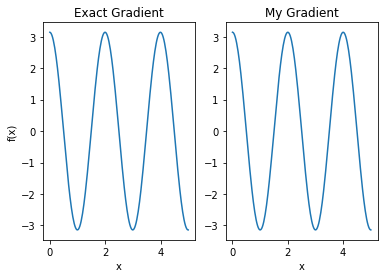

In [88]:
custom_dif = MyDifferentiator()
custom_grad_expectation = tfq.layers.Expectation(differentiator=custom_dif)

# Now let's get the gradients with finite diff.
with tf.GradientTape() as g:
    g.watch(values_tensor)
    exact_outputs = expectation_calculation(my_circuit,
                                            operators=[pauli_x],
                                            symbol_names=['alpha'],
                                            symbol_values=values_tensor)

analytic_finite_diff_gradients = g.gradient(exact_outputs, values_tensor)

# Now let's get the gradients with custom diff.
with tf.GradientTape() as g:
    g.watch(values_tensor)
    my_outputs = custom_grad_expectation(my_circuit,
                                         operators=[pauli_x],
                                         symbol_names=['alpha'],
                                         symbol_values=values_tensor)

my_gradients = g.gradient(my_outputs, values_tensor)

plt.subplot(1, 2, 1)
plt.title('Exact Gradient')
plt.plot(input_points, analytic_finite_diff_gradients.numpy())
plt.xlabel('x')
plt.ylabel('f(x)')
plt.subplot(1, 2, 2)
plt.title('My Gradient')
plt.plot(input_points, my_gradients.numpy())
plt.xlabel('x')

This new differentiator can now be used to generate differentiable ops.

Key Point: A differentiator that has been previously attached to an op must be refreshed before attaching to a new op, because a differentiator may only be attached to one op at a time.

In [89]:
# Create a noisy sample based expectation op.
expectation_sampled = tfq.get_sampled_expectation_op(
    cirq.DensityMatrixSimulator(noise=cirq.depolarize(0.01)))

# Make it differentiable with your differentiator:
# Remember to refresh the differentiator before attaching the new op
custom_dif.refresh()
differentiable_op = custom_dif.generate_differentiable_op(
    sampled_op=expectation_sampled)

# Prep op inputs.
circuit_tensor = tfq.convert_to_tensor([my_circuit])
op_tensor = tfq.convert_to_tensor([[pauli_x]])
single_value = tf.convert_to_tensor([[my_alpha]])
num_samples_tensor = tf.convert_to_tensor([[1000]])

with tf.GradientTape() as g:
    g.watch(single_value)
    forward_output = differentiable_op(circuit_tensor, ['alpha'], single_value,
                                       op_tensor, num_samples_tensor)

my_gradients = g.gradient(forward_output, single_value)

print('---TFQ---')
print('Foward:  ', forward_output.numpy())
print('Gradient:', my_gradients.numpy())
print('---Original---')
print('Forward: ', my_expectation(pauli_x, my_alpha))
print('Gradient:', my_grad(pauli_x, my_alpha))

---TFQ---
Foward:   [[0.748]]
Gradient: [[1.8465817]]
---Original---
Forward:  0.80901700258255
Gradient: 1.8063604831695557


Success: Now you can use all the differentiators that TensorFlow Quantum has to offer—and define your own.